In [1]:
# !pip install -qU tensorflow==2.8
!pip install -q keras-cv-attention-models
!apt -y install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.10.1 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.61.0 which is incompatible.
tfx-bsl 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-transform 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-serving-api 2.10.0 requires tensorflow<3,>=2.10.0, but you have tensorflow 2.9.2 which is incompatible.
ortools 9.5.2237 requires protobuf>=4.21.5, but you have protobuf 3.19.6 which is incompatible.
onnx 1.13.0 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
nnabla 1.34.0 requires protobuf<=3.19.4; platform_system != "Windows", but you have protobuf 3.19.6 wh

In [2]:
import os
import cv2
import glob
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import math
import keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB5
from tensorflow.keras.applications import ResNet50
from keras_cv_attention_models import efficientnet
from tensorflow.keras.optimizers import Adam

In [3]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices : {strategy.num_replicas_in_sync}")

Number of devices : 2


In [4]:
configs = dict(
    image_width = 224,
    image_height = 224,
    batch_size = 32*strategy.num_replicas_in_sync,
    batch_division = 32*strategy.num_replicas_in_sync*2,
    model_name = 'Efficient-net-kfold-2',
    epochs = 10,
    learning_rate = 0.001,
    lr_decay_rate = 0.1,
    dr_rate = 0.5,
    n_splits = 5,
    optimizer = 'adam',
    loss_fn = 'binary_crossentropy',
    metrics = ['pFBeta', 'f1', 'auc'],
    AUTO = tf.data.AUTOTUNE,
    BUFFER_SIZE = 1024,
    SEED = 42
)

In [5]:
import random
def seed_everything(seed=configs['SEED']):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything()

In [6]:
train_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

train_dir = '/kaggle/input/rnsa-train-data-with-roi-224x224/train_images_processed_cv2_dicomsdl_512/'
test_dir = '/kaggle/input/rsna-breast-cancer-detection/test_images/'

In [7]:
train = train_df[['patient_id', 'image_id', 'laterality', 'view', 'cancer', 'age', 'biopsy', 'invasive', 'implant', 'difficult_negative_case']]
train['image_path'] = train.apply(lambda x: train_dir + str(int(x.patient_id)) + '/' + str(int(x.image_id)) + '.png', axis=1)
# train['cancer'] = train['cancer'].apply(lambda x: str(x))
train.head()

,patient_id,image_id,laterality,view,cancer,age,biopsy,invasive,implant,difficult_negative_case,image_path
0,10006,462822612,L,CC,0,61.0,0,0,0,False,/kaggle/input/rnsa-train-data-with-roi-224x224...
1,10006,1459541791,L,MLO,0,61.0,0,0,0,False,/kaggle/input/rnsa-train-data-with-roi-224x224...
2,10006,1864590858,R,MLO,0,61.0,0,0,0,False,/kaggle/input/rnsa-train-data-with-roi-224x224...
3,10006,1874946579,R,CC,0,61.0,0,0,0,False,/kaggle/input/rnsa-train-data-with-roi-224x224...
4,10011,220375232,L,CC,0,55.0,0,0,0,True,/kaggle/input/rnsa-train-data-with-roi-224x224...


In [8]:
from sklearn.model_selection import StratifiedGroupKFold
kf = StratifiedGroupKFold(n_splits=configs['n_splits'], shuffle=True, random_state=configs['SEED'])

for k, (_, test_idx) in enumerate(kf.split(train, train.cancer, groups = train.patient_id)):
    train.loc[test_idx, "fold"] = k
train.fold = train.fold.astype(int)
train.groupby("fold").cancer.mean()

fold
0    0.021222
1    0.021601
2    0.022612
3    0.020292
4    0.020101
Name: cancer, dtype: float64

In [9]:
def load_dataset(df):
    paths = df.image_path.values
    labels = df.cancer.values
    
    def decode_img(paths, labels):
        raw = tf.io.read_file(paths)
        img = tf.io.decode_png(raw, channels=3)
        img = tf.image.resize(img, (configs['image_width'], configs['image_height']))
#         img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, (configs['image_width'], configs['image_height'], 3))
        return img, tf.cast(labels, tf.float32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=configs['AUTO'])
    return ds

In [10]:
def augment_image(image, label, image_size=(224, 224), p=0.5):
    # Resize and random crop
    image = tf.image.resize(image, [image_size[0]+10, image_size[1]+10])
    image = tf.image.random_crop(image, [*image_size, 3])
    
    # Random brightness and contrast
    if tf.random.stateless_uniform([], seed=(1, 1)) < p:
        image = tf.image.stateless_random_brightness(image, max_delta=0.1, seed=(2, 2))
        image = tf.image.stateless_random_contrast(image, lower=0.9, upper=1.1, seed=(3, 3))
    
    # Random hue and saturation
    if tf.random.stateless_uniform([], seed=(4, 4)) < p:
        image = tf.image.stateless_random_hue(image, max_delta=0.05, seed=(5, 5))
        image = tf.image.stateless_random_saturation(image, lower=0.9, upper=1.1, seed=(6, 6))
    
    # Random flips and rotations
    if tf.random.stateless_uniform([], seed=(7, 7)) < p:
        image = tf.image.stateless_random_flip_left_right(image, seed=(8, 8))
    if tf.random.stateless_uniform([], seed=(9, 9)) < p:
        image = tf.image.stateless_random_flip_up_down(image, seed=(10, 10))
#     if tf.random.stateless_uniform([], seed=(11, 11)) < p:
#         image = tf.image.rot90(image, k=tf.random.stateless_uniform([], minval=0, maxval=4, seed=(12, 12)))
    
    # Normalize pixel values
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label


In [11]:
def get_dataset(df, shuffle=True, augment=True, repeat=True):
    
    ds = load_dataset(df)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    ds = ds.with_options(options)
    
    if augment is not None:
        ds = ds.map(augment_image)
        
    if repeat:
        ds = ds.repeat()
        
    if shuffle:
        ds = ds.shuffle(configs['BUFFER_SIZE'])
        
    ds = ds.batch(configs['batch_size'])
    ds = ds.prefetch(configs['AUTO'])
    return ds

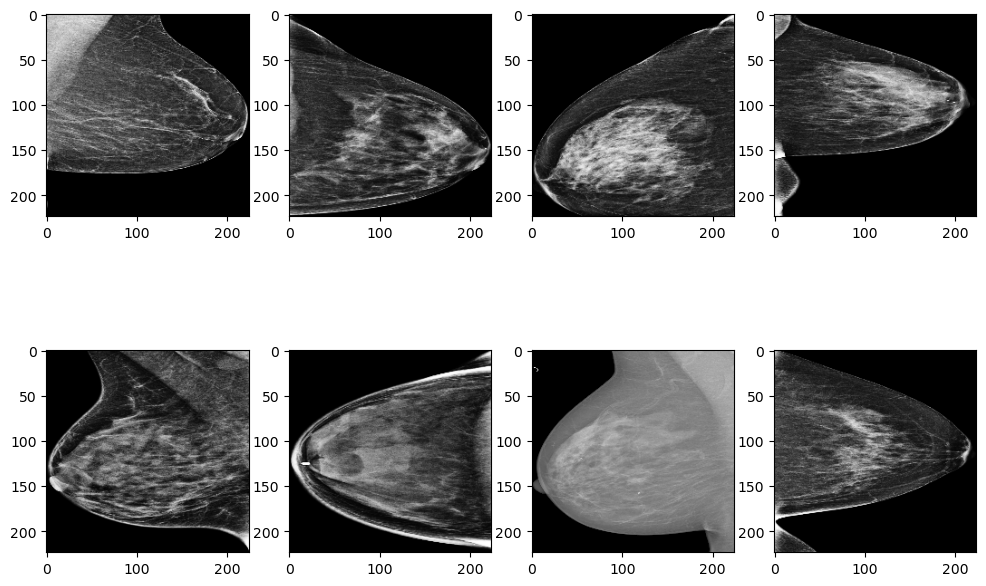

In [12]:
from matplotlib.image import imread
from matplotlib.pyplot import imshow
import random

plt.figure(figsize=(12, 8))

for i in range(8):
    index = random.randint(0, 50000)
    plt.subplot(2, 4, i+1)
    path = train['image_path'][index]
    image = imread(path)
    imshow(image);

In [13]:
from tensorflow import keras

class pFBeta(keras.metrics.Metric):
    def __init__(self, beta=1, epsilon=1e-5, name="pF1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta  # when beta=1, metric is pF1
        self.epsilon = epsilon
        self.pos = self.add_weight(name="pos", initializer="zeros")
        self.ctp = self.add_weight(name="ctp", initializer="zeros")
        self.cfp = self.add_weight(name='cfp', initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.reduce_sum(y_true)
        ctp = tf.reduce_sum(y_pred[y_true==1])
        cfp = tf.reduce_sum(y_pred[y_true==0])
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)
    
    def result(self):
        beta_squared = self.beta * self.beta
        c_precision = self.ctp / (self.ctp + self.cfp + self.epsilon)
        c_recall = self.ctp / (self.pos + self.epsilon)
        result = (1 + beta_squared) * c_precision * c_recall / (beta_squared * c_precision + c_recall)
        return tf.cond(c_precision >0 and c_recall >0, lambda: result, lambda: 0.0)
    
    def reset_state(self):
        self.pos.assign(0)
        self.ctp.assign(0)
        self.cfp.assign(0)




train_num = int(len(train)*(configs['n_splits'] - 1)/configs['n_splits'])
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,
                                                       decay_steps=train_num//configs['batch_size'],
                                                       decay_rate=0.9)

In [14]:
def build_model():
    base_model = efficientnet.EfficientNetV1B0(input_shape=(configs['image_width'], configs['image_height'], 3), 
                                               num_classes=0,
                                               pretrained="noisy_student",
                                               dropout=0.5,
                                              )
    inputs = base_model.inputs
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs=inputs, outputs=output)
    
    
    optimizer = Adam(learning_rate=lr_schedule)
    pf1 = pFBeta(name="pF1")
    auc = keras.metrics.AUC(name="auc")
    f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        optimizer=optimizer,
        metrics = ["accuracy", f1, pf1, auc])
    
    return model
    

In [15]:
historys = []

for fold in range(configs['n_splits']):
    tf.keras.backend.clear_session()
    print(f"{'*'*12} Fold {fold} {'*'*12}")
    
    train_data_fold = train[train.fold!=fold].reset_index(drop=True)
    val_data_fold = train[train.fold==fold].reset_index(drop=True)
    
    train_ds = get_dataset(train_data_fold, shuffle=True, repeat=True)
    val_ds = get_dataset(val_data_fold, shuffle=False, repeat=False)
    
    with strategy.scope():
        seed_everything()
        model = build_model()
    
    save_path = f"rsna_with_roi_model_fold{fold}.h5"
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=5,
        verbose=1,
        mode='min',
        restore_best_weights=True)
    
    callback = ModelCheckpoint(save_path, 
                                 monitor="val_loss",
                                 save_best_only=True,
#                                  initial_value_threshold=0.3,
                                 verbose=1)
    callbacks = [early_stopping, callback]
    history = model.fit(train_ds, 
                        steps_per_epoch= len(train_data_fold)//configs['batch_division'],
                        validation_data=val_ds,
                        validation_steps = len(val_data_fold)//configs['batch_division'],
                        callbacks=callbacks,
                        epochs=20,
                     )
    model.save(save_path)
    historys.append(history)

************ Fold 0 ************
21999024/21999024 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv1-b0-noisy_student.h5
Epoch 1/20
341/341 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.8987 - f1_score: 0.0383 - pF1: 0.0360 - auc: 0.4881
Epoch 1: val_loss improved from inf to 0.11352, saving model to rsna_with_roi_model_fold0.h5
341/341 [==============================] - 226s 510ms/step - loss: 0.2894 - accuracy: 0.8987 - f1_score: 0.0383 - pF1: 0.0360 - auc: 0.4881 - val_loss: 0.1135 - val_accuracy: 0.9798 - val_f1_score: 0.0000e+00 - val_pF1: 0.0197 - val_auc: 0.4811
Epoch 2/20
341/341 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9660 - f1_score: 0.0262 - pF1: 0.0320 - auc: 0.5342
Epoch 2: val_loss improved from 0.11352 to 0.10739, saving model to rsna_with_roi_model_fold0.h5
341/341 [==============================] - 153s 449ms/step - loss: 0.1545 - accuracy

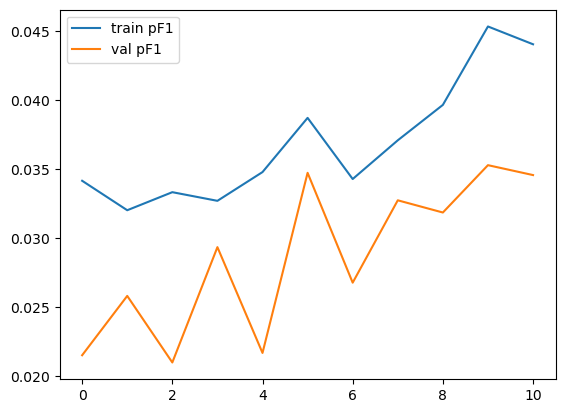

In [16]:
epochs = range(len(history.history['val_pF1']))
plt.plot(epochs, history.history['pF1'], label='train pF1')
plt.plot(epochs, history.history['val_pF1'], label='val pF1')
plt.legend()
plt.show()